## Partie modélisation

In [31]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.feature_selection import r_regression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../4072eb5e-e963-4a17-a794-3ea028d0a9c4.csv")
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True)

In [3]:
# Définir les tranches de BMI
bins = [0, 18.5, 24.9, 29.9, 40, 100]  # Tranches de BMI
labels = ['Sous-poids', 'Poids normal', 'Surpoids', 'Obésité', 'Obésité sévère']

# Ajouter une nouvelle colonne dans le DataFrame pour les tranches de BMI
df["BMI_category"] = pd.cut(df['bmi'], bins=bins, labels=labels, right=False)

In [4]:
del df["index"]
df.head()

,age,sex,bmi,children,smoker,region,charges,BMI_category
0,19,female,27.900,0,yes,southwest,16884.92400,Surpoids
1,18,male,33.770,1,no,southeast,1725.55230,Obésité
2,28,male,33.000,3,no,southeast,4449.46200,Obésité
3,33,male,22.705,0,no,northwest,21984.47061,Poids normal
4,32,male,28.880,0,no,northwest,3866.85520,Surpoids


In [5]:
df["BMI_category"]

0           Surpoids
1            Obésité
2            Obésité
3       Poids normal
4           Surpoids
            ...     
1332         Obésité
1333         Obésité
1334         Obésité
1335        Surpoids
1336        Surpoids
Name: BMI_category, Length: 1337, dtype: category
Categories (5, object): ['Sous-poids' < 'Poids normal' < 'Surpoids' < 'Obésité' < 'Obésité sévère']

In [6]:
features_of_interest = [
    "age",
    "sex",
    "bmi",
    "children",
    "smoker",
    "region",
    "BMI_category"
]

numerical_column = [
    "age",
    "bmi",
    "children"
]

ordinal_column = [
    "sex",
    "smoker",
    "BMI_category"
]

categorical_column = [
    "region",
]


target_name = "charges"
data, target, numerical_data, ordinal_data, categorical_data = (
    df[features_of_interest],
    df[target_name],
    df[numerical_column],
    df[ordinal_column],
    df[categorical_column]
)

### dummy model

In [7]:
dummy_model = DummyRegressor()
_ = dummy_model.fit(data,target)

In [8]:
target_predicted = dummy_model.predict(data)
target_predicted

array([13279.12148666, 13279.12148666, 13279.12148666, ...,
       13279.12148666, 13279.12148666, 13279.12148666], shape=(1337,))

On obtient bien un modèle qui nous prédit pour tout le monde la moyenne des charges...

In [9]:
rmse = root_mean_squared_error(dummy_model.predict(data), target)
rmse

12105.829878868954

Avec un rmse de 12105 ce qui est beaucoup

### première regression linéaire

Les r2 pour nos valeurs numériques :

In [10]:
r_regression(numerical_data, target)

array([0.29830821, 0.19840083, 0.06738935])

In [11]:
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", StandardScaler(), numerical_column)
    ],
    remainder="passthrough",
)

model = make_pipeline(preprocessor, LinearRegression())
model.fit(data,target)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker',
                                                   'BMI_category']),
                                                 ('numeric', StandardScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('linearregression', LinearRegression())])

In [12]:
cv_results = cross_validate(
    model,
    data,
    target,
    cv=10,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    return_estimator=True,
)

In [13]:
model[-1].coef_

array([  575.6109002 ,   221.73556721,  -416.56396828,  -380.78249913,
        -129.04083593, 23832.34533609,  -516.75126634,  3605.98273598,
        1556.30054375,   568.83982387])

In [14]:
model.score(data,target)

0.7542837618107281

In [15]:
import numpy as np

train_error = -cv_results["train_score"]
print(
    np.sqrt(train_error.mean())
)

5998.540466326356


On obtient en moyenne un rmse d'environ 6000 ce qui est toujours mieux que le dummy model mais pas tant...

### avec polynomiale features

In [16]:
X_train, X_test, y_train, y_test =train_test_split(data,target,random_state=42, test_size=0.2)

In [17]:
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", StandardScaler(), numerical_column)
    ],
    remainder="passthrough",
)

model = make_pipeline(preprocessor, PolynomialFeatures(2), LinearRegression())
model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker',
                                                   'BMI_category']),
                                                 ('numeric', StandardScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [18]:
root_mean_squared_error(model.predict(X_test), y_test)

4262.04196374671

In [19]:
model.score(X_test,y_test)

0.901146110222109

On obtient un meilleur score. Etudions le poid de nos nouvelles features :

In [20]:
weights = model[-1].coef_
weights

array([-1.44561717e-13,  3.74702083e+02, -3.49605584e+01,  3.45983219e+02,
       -6.85724744e+02, -3.45861207e+02,  1.22383809e+04, -3.67713115e+02,
        2.67425614e+03,  1.32189607e+01,  8.75148579e+02,  3.74702083e+02,
        1.36424205e-12,  3.06954462e-12,  1.81898940e-12, -6.48074115e+02,
        3.03573622e+03, -7.20115018e+01,  1.36396026e+02,  3.91816267e+02,
        4.39734826e+02, -3.49605584e+01,  2.47268872e-12,  9.09494702e-13,
        4.74511028e+02,  2.93567051e+03, -1.00344968e+02,  5.41130969e+02,
        2.64280800e+02,  5.55714254e+02,  3.45983219e+02, -6.82121026e-13,
       -1.92306954e+02,  2.60170571e+03, -4.83164450e+02,  1.03530899e+03,
       -9.03180362e+02, -7.87736358e+01, -6.85724744e+02,  2.00088349e+01,
        3.66526842e+03,  2.87807805e+02,  9.61420150e+02,  2.60302255e+02,
       -4.15268649e+01, -3.45861207e+02,  2.14380027e+02,  1.17488181e+02,
        2.46688913e+01,  2.63163499e+02, -2.23632883e+02,  1.22383809e+04,
       -2.66196248e+03, -

In [21]:
null_features_weight = [w for w in weights if abs(w) < 0.001]
len(null_features_weight)

7

On a 7 des features dont on peut se débarasser. Utilisons maintenant Lasso.

### avec lasso

In [25]:
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", StandardScaler(), numerical_column)
    ],
    remainder="passthrough",
)

model = make_pipeline(preprocessor, PolynomialFeatures(2), Lasso(1))
model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker',
                                                   'BMI_category']),
                                                 ('numeric', StandardScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('lasso', Lasso(alpha=1))])

In [26]:
model.score(X_test,y_test)

0.9012689707155939

In [27]:
root_mean_squared_error(model.predict(X_test), y_test)

4259.392602241426

On va faire varier les paramètres pour trouver le meilleurs :

In [43]:
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("poly", PolynomialFeatures()),
    ("lasso", Lasso(max_iter=10000))
])

param_grid = {
    "poly__degree": [2, 3], 
    "lasso__alpha": np.linspace(1, 100, 100), 
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X_train, y_train)

grid_search.best_params_

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.213e+08, tolerance: 1.138e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.428e+07, tolerance: 1.168e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarn

{'lasso__alpha': np.float64(55.0), 'poly__degree': 2}

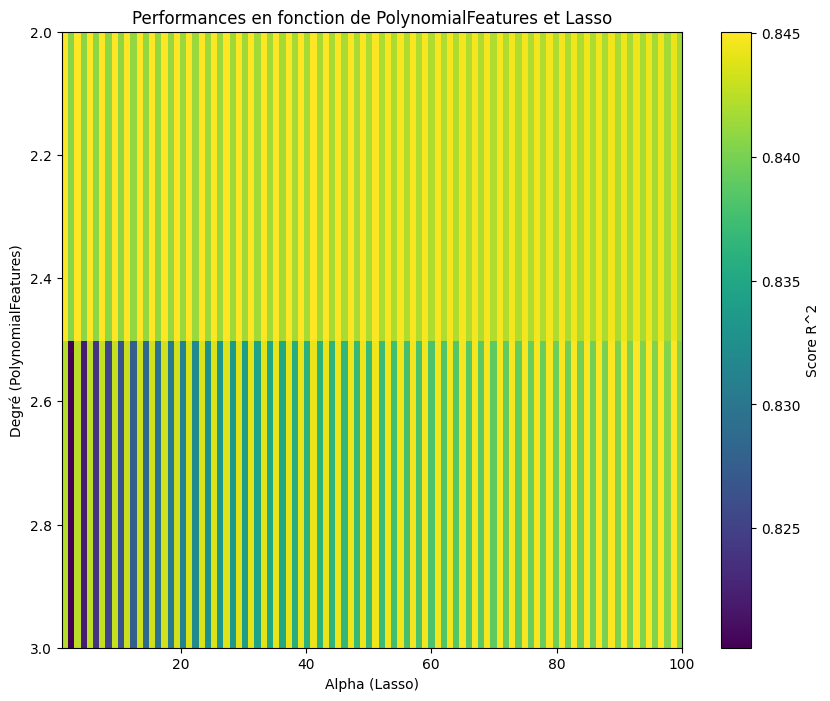

In [44]:
results = grid_search.cv_results_
degrees = param_grid["poly__degree"]
alphas = param_grid["lasso__alpha"]
scores = results["mean_test_score"].reshape(len(degrees), len(alphas))

# Visualisation
plt.figure(figsize=(10, 8))
plt.imshow(scores, interpolation="nearest", cmap="viridis", aspect="auto", 
           extent=[min(alphas), max(alphas), min(degrees), max(degrees)])
plt.colorbar(label="Score R^2")
plt.title("Performances en fonction de PolynomialFeatures et Lasso")
plt.xlabel("Alpha (Lasso)")
plt.ylabel("Degré (PolynomialFeatures)")
plt.gca().invert_yaxis()
plt.show()

In [45]:
model = make_pipeline(preprocessor, PolynomialFeatures(2), Lasso(55))
model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker',
                                                   'BMI_category']),
                                                 ('numeric', StandardScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('lasso', Lasso(alpha=55))])

In [46]:
model.score(X_test,y_test)

0.9011396766208613

In [47]:
root_mean_squared_error(model.predict(X_test), y_test)

4262.180652433775